In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# Data Preparation

# Parameters
tickers = ['AAPL', 'COKE', 'VZ', 'F']
tickers.sort()

start = '2016-01-01'

# YF download
df = yf.download(tickers, start=start)

# Reformat Dataframe
df = df.stack().reset_index()

# Add daily return column
df['Return'] = df.groupby("Ticker")['Adj Close'].pct_change()

df = df.dropna()

df

[*********************100%%**********************]  4 of 4 completed
C:\Users\andre\AppData\Local\Temp\ipykernel_18356\1719358244.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack().reset_index()


Price,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Return
4,2016-01-05,AAPL,23.288240,25.677500,26.462500,25.602501,26.437500,223164000,-0.025059
5,2016-01-05,COKE,166.498169,176.740005,179.410004,174.300003,177.020004,32600,0.009655
6,2016-01-05,F,8.630338,13.720000,14.000000,13.510000,13.970000,50267500,-0.017896
7,2016-01-05,VZ,29.956108,46.500000,46.549999,45.630001,46.200001,15632800,0.013735
8,2016-01-06,AAPL,22.832500,25.174999,25.592501,24.967501,25.139999,273829600,-0.019570
...,...,...,...,...,...,...,...,...,...
8687,2024-08-20,VZ,40.849998,40.849998,40.959999,40.630001,40.660000,8784000,0.002700
8688,2024-08-21,AAPL,226.399994,226.399994,227.979996,225.050003,226.520004,34729100,-0.000486
8689,2024-08-21,COKE,1321.290039,1321.290039,1322.589966,1284.989990,1292.040039,70200,0.042052
8690,2024-08-21,F,10.850000,10.850000,10.970000,10.750000,10.840000,48881900,0.015918


In [3]:
# Create assets dataframe

assets = df.groupby('Ticker')['Return'].mean().rename("Expected Return").to_frame().reset_index()

assets['Volatility'] = df.groupby('Ticker')['Return'].std().to_list()

assets['Sharpe Ratio'] = assets['Expected Return'] / assets['Volatility']

assets

,Ticker,Expected Return,Volatility,Sharpe Ratio
0,AAPL,0.001203,0.018265,0.065850
1,COKE,0.001246,0.023878,0.052186
2,F,0.000374,0.023549,0.015893
3,VZ,0.000228,0.012394,0.018399


In [4]:
# Returns dataframe
return_matrix = df[['Date','Ticker','Return']].pivot(index='Date', columns='Ticker', values='Return').dropna()

return_matrix

Ticker,AAPL,COKE,F,VZ
Date,,,,
2016-01-05,-0.025059,0.009655,-0.017896,0.013735
2016-01-06,-0.019570,0.018162,-0.044461,-0.009034
2016-01-07,-0.042205,-0.014004,-0.031274,-0.005492
2016-01-08,0.005288,0.002649,-0.012598,-0.009720
2016-01-11,0.016192,-0.029960,0.018341,0.005800
...,...,...,...,...
2024-08-15,0.013531,0.009538,0.027505,-0.021027
2024-08-16,0.005918,-0.007220,0.004780,0.014236
2024-08-19,-0.000708,0.010404,0.019981,0.003201


In [5]:
# Covariance Matrix
cov_matrix = return_matrix.cov().values

cov_matrix

array([[3.33605454e-04, 1.08169355e-04, 1.46861165e-04, 5.03437976e-05],
       [1.08169355e-04, 5.70170794e-04, 1.38455337e-04, 6.36601282e-05],
       [1.46861165e-04, 1.38455337e-04, 5.54554106e-04, 6.79248954e-05],
       [5.03437976e-05, 6.36601282e-05, 6.79248954e-05, 1.53620414e-04]])

In [6]:
# Expected Returns Vector
expected_returns = assets['Expected Return'].values

expected_returns

array([0.00120273, 0.0012461 , 0.00037427, 0.00022805])

In [7]:
# Portfolio metric functions
def portfolio_return(weights, expected_returns):
    return np.sum(weights * expected_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(np.matmul(weights,cov_matrix),weights.T))

def negative_sharpe_ratio(weights, expected_returns, cov_matrix):
    port_er = portfolio_return(weights, expected_returns)
    port_std = portfolio_volatility(weights, cov_matrix)
    return -port_er / port_std

In [8]:
# Display Weights Function
def display_weights(tickers, weights):
    df = pd.DataFrame()
    df['Ticker'] = tickers
    df['Weight'] = [round(weight, 2) for weight in weights]

    display(df)

In [9]:
# Baseline results

# Initial Weights
size = len(tickers)
initial_weights = np.array([1/size] * size)

# Baseline Results
port_return = portfolio_return(initial_weights, expected_returns)
port_volatiliy = portfolio_volatility(initial_weights,cov_matrix)
port_sharpe = port_return / port_volatiliy

#Display
display_weights(tickers, initial_weights)
print(f"Portfolio Return: {round(port_return,2)} %")
print(f"Portfolio Volatility: {round(port_volatiliy,2)} %")
print(f"Portfolio Sharpe Ratio: {round(port_sharpe,2)}")

,Ticker,Weight
0,AAPL,0.25
1,COKE,0.25
2,F,0.25
3,VZ,0.25


Portfolio Return: 0.0 %
Portfolio Volatility: 0.01 %
Portfolio Sharpe Ratio: 0.06


In [10]:
# Optimization

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # weights sum to 1

# Result
result = minimize(negative_sharpe_ratio, initial_weights, 
                  args=(expected_returns, cov_matrix),
                  method='SLSQP', constraints=constraints)

optimal_weights = result.x

optimal_weights

array([ 0.75820265,  0.39149003, -0.14258941, -0.00710327])

In [11]:
# Optimal Results
opt_port_return = portfolio_return(optimal_weights, expected_returns)
opt_port_volatility = portfolio_volatility(optimal_weights,cov_matrix)
opt_port_sharpe_ratio = opt_port_return / opt_port_volatility

# Display
display_weights(tickers,optimal_weights)
print(f"Optimized Portfolio Return: {round(opt_port_return,2)} %")
print(f"Optimized Portfolio Volatility: {round(opt_port_volatility,2)} %")
print(f"Optimized Portfolio Sharpe Ratio: {round(opt_port_sharpe_ratio,2)}")

,Ticker,Weight
0,AAPL,0.76
1,COKE,0.39
2,F,-0.14
3,VZ,-0.01


Optimized Portfolio Return: 0.0 %
Optimized Portfolio Volatility: 0.02 %
Optimized Portfolio Sharpe Ratio: 0.08


In [12]:
# Efficient Frontier Chart

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Mean Variance Efficient function
def mve_portfolio(target_return, expected_returns, cov_matrix):
    n = len(tickers)
    args = (expected_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x, expected_returns) - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(portfolio_volatility, n*[1./n,], args=args[1],
                      method='SLSQP', constraints=constraints)
    return result.x

In [13]:
# Pro
n_points = 100
target_returns = np.linspace(0,2*opt_port_return, n_points)
mve_portfolios = [mve_portfolio(target, expected_returns, cov_matrix) for target in target_returns]

returns = [portfolio_return(w, expected_returns) for w in mve_portfolios]
volatilities = [portfolio_volatility(w, cov_matrix) for w in mve_portfolios]

portfolios = pd.DataFrame()
portfolios['Name'] = [f"Portfolio {x+1}" for x in range(len(mve_portfolios))]

for index in range(len(tickers)):
    portfolios[tickers[index]] = np.array([row[index] for row in mve_portfolios])
    portfolios[tickers[index]] = round(portfolios[tickers[index]],2)
    
portfolios['Expected Return'] = returns
portfolios['Volatility'] = volatilities
portfolios['Sharpe Ratio'] = portfolios['Expected Return'] / portfolios['Volatility']

portfolios

,Name,AAPL,COKE,F,VZ,Expected Return,Volatility,Sharpe Ratio
0,Portfolio 1,-0.17,-0.09,0.20,1.06,-8.779441e-14,0.013994,-6.273663e-12
1,Portfolio 2,-0.15,-0.08,0.19,1.04,2.716697e-05,0.013716,1.980630e-03
2,Portfolio 3,-0.13,-0.07,0.18,1.02,5.433394e-05,0.013448,4.040291e-03
3,Portfolio 4,-0.11,-0.06,0.18,1.00,8.150092e-05,0.013190,6.179087e-03
4,Portfolio 5,-0.09,-0.05,0.17,0.98,1.086679e-04,0.012942,8.396368e-03
...,...,...,...,...,...,...,...,...
95,Portfolio 96,1.59,0.85,-0.44,-1.00,2.580862e-03,0.035964,7.176183e-02
96,Portfolio 97,1.61,0.86,-0.45,-1.02,2.608029e-03,0.036395,7.165815e-02
97,Portfolio 98,1.63,0.87,-0.46,-1.04,2.635196e-03,0.036827,7.155590e-02
98,Portfolio 99,1.64,0.88,-0.47,-1.06,2.662363e-03,0.037259,7.145507e-02


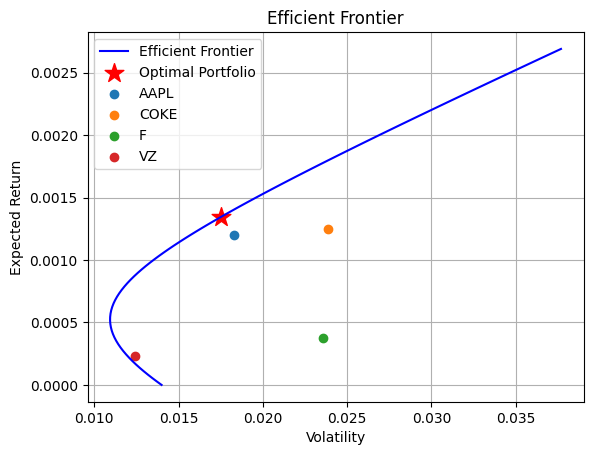

In [14]:
plt.plot(volatilities, returns, 'b-', label='Efficient Frontier')
plt.scatter(opt_port_volatility, opt_port_return, color='r', marker='*', s=200, label='Optimal Portfolio')

# Plot individual assets
for i, ticker in enumerate(tickers):
    plt.scatter(assets['Volatility'].iloc[i], assets['Expected Return'].iloc[i], label=ticker)

plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)
plt.show()

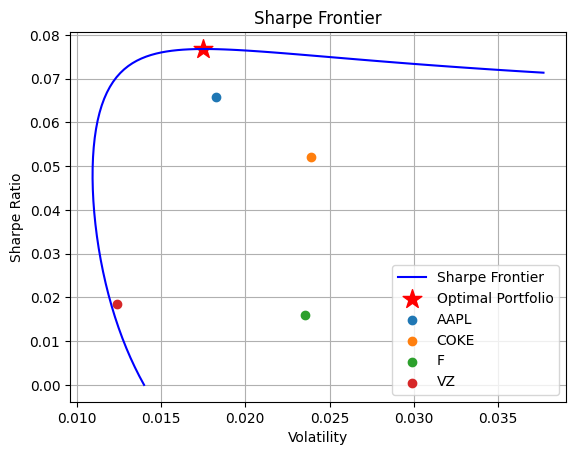

In [15]:
# Sharpe Graph
plt.plot(portfolios['Volatility'], portfolios['Sharpe Ratio'], 'b-', label='Sharpe Frontier')
plt.scatter(opt_port_volatility, opt_port_sharpe_ratio, color='r', marker='*', s=200, label='Optimal Portfolio')

# Plot individual assets
for i, ticker in enumerate(tickers):
    plt.scatter(assets['Volatility'].iloc[i], assets['Sharpe Ratio'].iloc[i], label=ticker)

    
plt.xlabel('Volatility')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Frontier')
plt.legend()
plt.grid(True)
plt.show()